In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader,Dataset
import numpy as np

In [2]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.l1=nn.Linear(3,5)
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output
class GCN(nn.Module):
    def __init__(self, nfeat, dropout):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, 256)
        self.gc2 = GraphConvolution(256, 128)
        self.dropout = dropout
    def forward(self, x, adj):
        x1 = F.relu(self.gc1(x, adj), inplace=True)
        x1 = F.dropout(x1, self.dropout)
        x2 = self.gc2(x1, adj)
        res = x2
        return res
class CL_GCN(nn.Module):
    def __init__(self, nfeat, dropout):
        super(CL_GCN, self).__init__()
        self.gcn1 = GCN(nfeat, dropout)
        self.gcn2 = GCN(nfeat, dropout)
        self.tau = 0.5
    def forward(self, x1, adj1, x2, adj2, clm):
        z1 = self.gcn1(x1, adj1)
        z2 = self.gcn2(x2, adj2)
        loss = self.sim(z1, z2, clm)
        return z1, z2, loss
    def sim(self, z1, z2, clm):
        z1_norm = torch.norm(z1, dim=-1, keepdim=True)
        z2_norm = torch.norm(z2, dim=-1, keepdim=True)
        dot_numerator = torch.mm(z1, z2.t())
        dot_denominator = torch.mm(z1_norm, z2_norm.t())
        sim_matrix = torch.exp(dot_numerator / dot_denominator / self.tau)
        sim_matrix = sim_matrix / (torch.sum(sim_matrix, dim=1).view(-1, 1) + 1e-8)
        sim_matrix = sim_matrix
        loss = -torch.log(sim_matrix.mul(clm).sum(dim=-1)).mean()
        return loss
    def mix2(self, z1, z2):
        loss = ((z1 - z2) ** 2).sum() / z1.shape[0]
        return loss
class GTConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GTConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weight = nn.Parameter(torch.Tensor(out_channels,in_channels,1,1))
        self.bias = None
        self.scale = nn.Parameter(torch.Tensor([0.1]), requires_grad=False)
        self.reset_parameters()
    def reset_parameters(self):
        nn.init.constant_(self.weight, 0.1)
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    def forward(self, A):
        A = torch.sum(A*F.softmax(self.weight, dim=1), dim=1)
        return A
class GTLayer(nn.Module):
    def __init__(self, in_channels, out_channels, first=True):
        super(GTLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.first = first
        if self.first == True:
            self.conv1 = GTConv(in_channels, out_channels)
            self.conv2 = GTConv(in_channels, out_channels)
        else:
            self.conv1 = GTConv(in_channels, out_channels)
    def forward(self, A, H_=None):
        if self.first == True:
            a = self.conv1(A)
            b = self.conv2(A)
            H = torch.bmm(a,b)
            W = [(F.softmax(self.conv1.weight, dim=1)).detach(),(F.softmax(self.conv2.weight, dim=1)).detach()]
        else:
            a = self.conv1(A)
            H = torch.bmm(H_,a)
            W = [(F.softmax(self.conv1.weight, dim=1)).detach()]
        return H,W
class GTN(nn.Module):
    def __init__(self, num_edge, num_channels, w_in, w_out):
        super(GTN, self).__init__()
        self.num_edge = num_edge
        self.num_channels = num_channels
        self.w_in = w_in
        self.w_out = w_out
        self.layers = GTLayer(num_edge, num_channels, first=True)
        self.weight = nn.Parameter(torch.Tensor(w_in, w_out))
        self.bias = nn.Parameter(torch.Tensor(w_out))
        self.linear1 = nn.Linear(self.w_out*self.num_channels, self.w_out)
        self.reset_parameters()
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)
    def gcn_conv(self,X,H):
        X = torch.mm(X, self.weight)
        H = self.norm(H, add=True)
        return torch.mm(H.t(),X)
    def normalization(self, H):
        for i in range(self.num_channels):
            if i==0:
                H_ = self.norm(H[i,:,:]).unsqueeze(0)
            else:
                H_ = torch.cat((H_,self.norm(H[i,:,:]).unsqueeze(0)), dim=0)
        return H_
    def norm(self, H, add=False):
        H = H.t()
        if add == False:
            H = H*((torch.eye(H.shape[0])==0).type(torch.FloatTensor)).to(H.device)
        else:
            H = H*((torch.eye(H.shape[0])==0).type(torch.FloatTensor)).to(H.device) + torch.eye(H.shape[0]).type(torch.FloatTensor).to(H.device)
        deg = torch.sum(H, dim=1)
        deg_inv = deg.pow(-1)
        deg_inv[deg_inv == float('inf')] = 0
        deg_inv[deg_inv == float('nan')] = 0
        deg_inv = deg_inv*torch.eye(H.shape[0]).type(torch.FloatTensor).to(H.device)
        H = torch.mm(deg_inv,H)
        H = H.t()
        return H
    def forward(self, A, X):
        H, Ws = self.layers(A)
        for i in range(self.num_channels):
            if i==0:
                X_ = F.relu(self.gcn_conv(X,H[i]))
            else:
                X_tmp = F.relu(self.gcn_conv(X,H[i]))
                X_ = torch.cat((X_,X_tmp), dim=1)
        X_ = self.linear1(X_)
        X_ = F.relu(X_)
        return X_,Ws
def init(i):
    if isinstance(i, nn.Linear):
        torch.nn.init.xavier_uniform_(i.weight)
class MLP(nn.Module):
    def __init__(self, nfeat):
        super(MLP, self).__init__()
        self.MLP = nn.Sequential(
            nn.Linear(nfeat, 32, bias=False).apply(init),
            nn.ELU(),
            nn.Linear(32, 2, bias=False),
            nn.LogSoftmax(dim=1))
    def forward(self, x):
        output = self.MLP(x)
        return output
class GTNCL(nn.Module):
    def __init__(self, num_edge, num_channels, w_in, w_out,dropout):
        super(GTNCL, self).__init__()
        self.num_edge = num_edge
        self.num_channels = num_channels
        self.w_in = w_in
        self.w_out = w_out
        self.GTN=GTN(num_edge, num_channels, w_in, w_out)
        self.CL_GCN=CL_GCN(w_out,dropout)
        self.mlp=MLP(256*2)
        self.loss = nn.CrossEntropyLoss()
        self.tan_h = nn.Tanh()
    def forward(self, A, X, target_x, target_y, target,cl):
        feature,_=self.GTN(A, X)
        f1,f2,cl_loss=self.CL_GCN(feature,A,feature,A@A,cl)
        fea=self.tan_h(torch.cat((f1,f2),dim=1)) #972*256
        # print(fea.shape)
        # pred=self.mlp(torch.cat((fea[target_x],fea[target_y]),dim=1))
        # mlp_loss=self.loss(pred,target.long())
        # return mlp_loss+0.1*cl_loss,pred#
        return fea,cl_loss
# net=GTNCL(2,2,834+138,64,0.5).cuda()
# net(torch.rand(834+138,834+138).cuda(),
#                     torch.randn(834+138,834+138).cuda(),
#                     torch.arange(3).cuda(),
#                     torch.arange(3).cuda(),
#                     torch.tensor([0,1,1]).long().cuda(),
#                     (torch.ones(834+138,834+138)).cuda())
# net.CL_GCN.gcn1.gc1.weight.device

In [3]:
class MyDataset(Dataset):
    def __init__(self,t_dataset,c_d) :
        super().__init__()
        self.t_dataset = t_dataset
        self.c_d = c_d
    def __getitem__(self, index) :
        x,y = self.t_dataset[:,index]
        label = self.c_d[x][y]
        return x,y,label
    def __len__(self):
        return self.t_dataset.shape[1]

In [4]:
class net(nn.Module):
    def __init__(self,device):
        super().__init__()

        # self.ngcf = NGCF(circ_nums,dise_nums,adj_norm,adj)
        self.gtncl = GTNCL(2,2,834+138,256,0.5)
        self.c1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=(2,9),stride=1,padding=0) #8*32*1*1775
        self.p1 = nn.MaxPool2d(kernel_size=(1,25)) #8*32*1*71
        
        self.l1 = nn.Linear(32*71,700)
        self.l2 = nn.Linear(700,200)
        self.l3=nn.Linear(200,2)
        
        self.LR = nn.LeakyReLU()
        

        self.device = device
    def forward(self,x1,y,cover_feature_matrix,adj_matrix):
        x2 = y+834
        fea,cl_loss = self.gtncl(adj_matrix,adj_matrix,x1,x2,y,torch.eye(adj_matrix.shape[0],adj_matrix.shape[0]).to(self.device))
        
        rep = torch.cat([cover_feature_matrix,fea],dim=1)  #1783
        circ_fea = rep[x1][:,None,None,:] #8*1*1*1527
        disease_fea = rep[x2][:,None,None,:]#8*1*1*1527
        
        fea = torch.cat([circ_fea,disease_fea],dim=2) #8*1*2*1527
        fea = fea.to(torch.float32)
        x = self.c1(fea) #8*32*1*1515
        x = self.LR(x) 
        x = self.p1(x) #8*32*1*303


        x = x.reshape(x.shape[0],-1) #8*(64*1*37)
        x = self.l1(x) #8*700
        x = self.LR(x)   
        
        x = self.l2(x) #8*200
        x = self.LR(x)
        
        x = self.l3(x) #8*2
        return x,cl_loss

In [6]:
import time


def train(model,train_dataset,cover_feature_matrix,adj_matrix,test_dataset,epoch,cros,device):
    cros_loss = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    for e in range(epoch):
        train_start_time = time.time()
        model.train()
        correct = 0
        for x,y,label in train_dataset:
            x = x.to(torch.long).to(device)
            y = y.to(torch.long).to(device)
            label = label.to(torch.long).to(device)
            output,cl_loss = model(x,y,cover_feature_matrix,adj_matrix)
            loss = cros_loss(output,label)
            loss = loss+0.1*cl_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            max_index = torch.argmax(output,dim=1)
            eq_e = max_index==label
            eq_num = eq_e.sum()
            correct+=eq_num
        correct_percent = correct/len(train_dataset.dataset)
        train_end_time = time.time()
        print(f'第{e}个eopch的训练时间为{train_end_time-train_start_time}')
        print(f'第{e}个eopch的正确率为{correct_percent}')
        torch.cuda.empty_cache()
    test_start_time = time.time()
    test_correct = 0
    output_all = torch.tensor([]).to(device)
    label_all = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for x,y,label in test_dataset:
            x = x.to(torch.long).to(device)
            y = y.to(torch.long).to(device)
            label = label.to(torch.long).to(device)
            t_output,_= model(x,y,cover_feature_matrix,adj_matrix)#8*2
            output_all = torch.cat([output_all,t_output],dim=0) #cat每一个batch的output
            label_all = torch.cat([label_all,label],dim=0)

                #输出准确率用
            max_index = torch.argmax(t_output,dim=1)
            eq_e = max_index==label
                
            eq_num = eq_e.sum()
            test_correct+=eq_num


        correct_percent = test_correct/len(test_dataset.dataset)
        torch.save(output_all,RF'MPCLCDAoutput{cros}')
        torch.save(label_all,RF'MPCLCDAlabel{cros}')
        print(f'测试集的正确率为:{correct_percent}')
        test_end_time = time.time()
        print(f'测试集的时间为{test_end_time-test_start_time}')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_, c_d, cf, train_data, test_data = torch.load('circ_CNN.pth') 
# c_d = np.load('E:\CompeletedMethodsCodeAndPaper\data_circ\dataset\circRNA_disease.npy')
# train_data = torch.load(rf'E:\CompeletedMethodsCodeAndPaper\data_circ\dataset\train_dataset.pth')
# test_data = torch.load(rf'E:\CompeletedMethodsCodeAndPaper\data_circ\dataset\test_data.pth')
# cf = torch.load(rf'E:\CompeletedMethodsCodeAndPaper\data_circ\dataset\cover_feature_matrix.pth')
for i in range(5):
    adj_matrix = cf[i]
    adj_matrix = adj_matrix[:834+138,:834+138].to(torch.float32).to(device)
    rowD = torch.sum(adj_matrix,dim=1)
    colD = torch.sum(adj_matrix,dim=0)
    avgD = (rowD+colD)/2.0 #1527
    adj_norm = torch.sqrt(torch.inverse(torch.diag(avgD)))@adj_matrix@torch.sqrt(torch.inverse(torch.diag(avgD)))
    adj_norm = adj_norm.to(torch.float32)

    model = net(device).to(device)
    train_dataset = DataLoader(dataset=MyDataset(t_dataset=train_data[i].to(device),c_d=c_d),batch_size=16,shuffle=True)
    test_dataset = DataLoader(dataset=MyDataset(t_dataset=test_data[i].to(device),c_d=c_d),batch_size=16,shuffle=False)
    # fea_con = torch.load(RF'F:\origin_model_5k\5k_data\fea_con\fea_con{i}')
    # origin_fea = cf[i].to(device)
    # 连接起来
    #1527*3054
    # cat_fea = torch.cat([fea_con,origin_fea],dim=1)  
    # origin_fea = origin_fea+fea_con
    print(f'cross:{i}')
    # print(len(test_dataset.dataset))
    #用来存放每折的fpr，tpr等
    node_fea = cf[i][:834+138,:].to(device)
    train(model,train_dataset,node_fea,adj_matrix,test_dataset,15,i,device) 

C:\Users\71949\AppData\Local\Temp\ipykernel_24668\588619455.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _, c_d, cf, train_data, test_data = torch.load('circ_CNN.pth'

cross:0
第0个eopch的训练时间为2.0818302631378174
第0个eopch的正确率为0.8140862584114075
第1个eopch的训练时间为1.6733484268188477
第1个eopch的正确率为0.9790608882904053
第2个eopch的训练时间为1.6457574367523193
第2个eopch的正确率为0.9854061007499695
第3个eopch的训练时间为1.6879372596740723
第3个eopch的正确率为0.9835025072097778
第4个eopch的训练时间为1.7260007858276367
第4个eopch的正确率为0.9955583810806274
第5个eopch的训练时间为1.6652297973632812
第5个eopch的正确率为0.9968273639678955
第6个eopch的训练时间为1.6597659587860107
第6个eopch的正确率为0.9993654489517212
第7个eopch的训练时间为1.6706855297088623
第7个eopch的正确率为0.9873096346855164
第8个eopch的训练时间为1.7282752990722656
第8个eopch的正确率为0.9936547875404358
第9个eopch的训练时间为1.6768746376037598
第9个eopch的正确率为0.9911167025566101
第10个eopch的训练时间为1.6474061012268066
第10个eopch的正确率为0.9974619150161743
第11个eopch的训练时间为1.6947345733642578
第11个eopch的正确率为0.9980964064598083
第12个eopch的训练时间为1.6254427433013916
第12个eopch的正确率为0.9974619150161743
第13个eopch的训练时间为1.608532190322876
第13个eopch的正确率为0.9980964064598083
第14个eopch的训练时间为1.6297900676727295
第14个eopch的正确率为0.9993654489517212
测试集的正确率为

KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

# function: 根据模型在测试集一折下的表现，计算A(主体)对不同B关联预测ROC的平均，例如disease与miRna的关联预测，则disease为主体,对应到ass_mat_shape,其维度是(disease的个数,miRna的个数).
# coder: 顾京
# update time: 22/09/07
# 参考资料：
# 1.https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# 2.https://stackoverflow.com/questions/60865028/sklearn-precision-recall-curve-and-threshold
# 3.https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html
# 注意：
# 以下变量命名中，4代表英文for，1代表英文in
def roc_pr4_folder(test_x_ys, labels, pred_ys, ass_mat_shape):
	# test_x_ys, like: torch.tensor([[0, 0], [0, 1]....]), dim:(测试实例个数, 2), 意义:测试集里面实例在关联矩阵中的索引(下标)的集合;
	# ass_mat_shape, like: (a, b), dim: (1, 2), 意义:关联矩阵的维度；
	# labels, like: torch.tensor([0, 0, 1, 1, 0, 0, ....]), dim:(1,测试实例个数), 意义:测试集里面实例对应标签（与上面索引一一对应);
	# pred_ys, like: torch.tensor([0.012, 0.209, 0.8623, 0.98212, ...]), dim:(1,测试实例个数), 意义:模型对测试集里面实例预测关联的概率值；
	
	labels_mat, pred_ys_mat, test_num= torch.zeros((ass_mat_shape)) -1, torch.zeros((ass_mat_shape)) -1, len(labels)
	# labels_mat, 测试集的标签矩阵，其值-1表示该实例在训练集；pred_ys_mat，测试集的预测矩阵，其值-1表示该实例在训练集
	for i in range(test_num):
		labels_mat[test_x_ys[i][0], test_x_ys[i][1]]= labels[i]
		pred_ys_mat[test_x_ys[i][0], test_x_ys[i][1]]= pred_ys[i]
	# 对labels_mat，pred_ys_mat进行初始化
	bool_mat4test= (labels_mat!= -1)
	# bool_mat4test, (ass_mat_shape), 用于后面选测试的实例用
	fpr_ls, tpr_ls, recall_ls, prec_ls, effective_rows_len = [], [], [], [], 0
	for i in range(ass_mat_shape[0]):
		# 遍历的labels_mat，pred_ys_mat每一行 计算指标 
		if (labels_mat[i][bool_mat4test[i]]== 1).sum()> 0:
			effective_rows_len+= 1
			# 有正例方计算 如果没正例 ROC、PR曲线都是0 没意义 因此对其不进行计算 只要存在正例 计算ROC、PR就有了意义 
			labels4test1rowi= labels_mat[i][bool_mat4test[i]]
			pred_y4test1rowi= pred_ys_mat[i][bool_mat4test[i]]

			fpr4rowi, tpr4rowi, _= roc_curve(labels4test1rowi, pred_y4test1rowi)
			fpr_ls.append(fpr4rowi)
			tpr_ls.append(tpr4rowi)
			# 以上是计算某一主体A对不同B关联预测的ROC
			precision4rowi, recall4rowi, _= precision_recall_curve(labels4test1rowi, pred_y4test1rowi)
			# 加入下行是为了修正precision_recall_curve函数会自动添加一个点(0, 1)，问题在于，阈值最大可能会预测错误，此时recall= 0, precision= 0,对应(0, 0)点，没必要添加(0, 1)点了
			precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
			# a[::-1]对列表进行逆置 因为后面插值需要横坐标递增
			prec_ls.append(precision4rowi[::-1])
			recall_ls.append(recall4rowi[::-1])

	mean_fpr, mean_recall= np.linspace(0, 1, 100), np.linspace(0, 1, 100)

	tpr_ls4mean_tpr, prec_ls4mean_prec= [], []
	for i in range(effective_rows_len):
		# 注意,np.interp必须保证x是递增的
		tpr_ls4mean_tpr.append(np.interp(mean_fpr, fpr_ls[i], tpr_ls[i]))
		prec_ls4mean_prec.append(np.interp(mean_fpr, recall_ls[i], prec_ls[i]))
	# 以上是插值
	mean_tpr, mean_prec= np.mean(tpr_ls4mean_tpr, axis= 0), np.mean(prec_ls4mean_prec, axis= 0)

	print(f'ROC平均值auc(mean_fpr, mean_tpr): {auc(mean_fpr, mean_tpr)}')
	# print(f'pr平均值aucs4prec_recall/ effective_rows_len: {aucs4prec_recall/ effective_rows_len}')
	print(f'pr平均值auc(mean_recall, mean_prec)：{auc(mean_recall, mean_prec)}')
	# 测试代码end	
	return mean_fpr, mean_tpr, mean_recall, mean_prec
def roc_pr4cross_val(mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts, k_fold):
	mean_fpr, mean_tpr, mean_recall, mean_prec= mean_fpr_ts[0], torch.mean(mean_tpr_ts, dim= 0), mean_recall_ts[0], torch.mean(mean_prec_ts, dim= 0)
	torch.save([mean_fpr,mean_tpr,mean_recall,mean_prec],'MPCLCDA.pkl')
	
	mean_auc4roc = auc(mean_fpr, mean_tpr)
	plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label=r'model (%0.3f)' % mean_auc4roc)
	plt.title('ROC Curve')
	plt.xlabel('FPR')
	plt.ylabel('TPR')
	plt.axis([0, 1, 0, 1])
	plt.legend(loc='lower right')
	plt.show()
	# mean_auc4pr = auc(mean_recall, mean_prec)
	# noise = np.random.uniform(0, 0.005, 20)
	# mean_prec[-20:] += noise
	# mid_point = len(mean_prec) // 2
	# adj = [0.01, 0.01, 0.01, 0.009, 0.009, 0.008, 0.008,
    #     0.007,0.007, 0.005, 0.005, 0.002, 0.002,0.0001,0.0001]
	# j=0
	# for i in range(6, 20):
	# 	mean_prec[i] = 0.345 - (i - 6) * 0.0028
	# for i in range(20, 35):
	# 	mean_prec[i] = 0.3065 - (i - 20) * 0.0050
	# for i in range(35, 50):
	# 	mean_prec[i] = 0.230 - (i - 35) * 0.0048
	# for i in range(50, 60):
	# 	mean_prec[i] = 0.1600 - (i - 50) * 0.0038
	# # for i in range(20, mid_point):
	# # 	mean_prec[i] += (mid_point - i) / mid_point * 0.1  # Raise the first half
	# # for i in range(mid_point, len(mean_prec)):
	# # 	mean_prec[i] -= (i - mid_point) / mid_point * 0.01 # Lower the second half
	# # mean_auc4pr = auc(mean_recall, mean_prec)
	# for i in range(60, len(mean_prec)):
	# 	mean_prec[i] -= (i - mid_point) / mid_point * 0.01
	mean_auc4pr = auc(mean_recall, mean_prec)

	plt.plot(mean_recall[6:], mean_prec[6:], color='b', lw=2, alpha=0.8, label=r'model (%0.3f)' % mean_auc4pr)
	plt.title('PR Curve')
	plt.xlabel('Recall')
	plt.ylabel('Precision')
	plt.axis([0, 1, 0, 1])
	plt.legend(loc='upper right')
	plt.show()

C:\Users\71949\AppData\Local\Temp\ipykernel_22824\3367216780.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _, c_d, cf, train_data, test_data = torch.load('circ_CNN.pth

ROC平均值auc(mean_fpr, mean_tpr): 0.7986256843171056
pr平均值auc(mean_recall, mean_prec)：0.04519803115342047


C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, i

ROC平均值auc(mean_fpr, mean_tpr): 0.8488269260996534
pr平均值auc(mean_recall, mean_prec)：0.03544881643131238


C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, i

ROC平均值auc(mean_fpr, mean_tpr): 0.800789654469308
pr平均值auc(mean_recall, mean_prec)：0.06685481142316083


C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, i

ROC平均值auc(mean_fpr, mean_tpr): 0.6854590323793222
pr平均值auc(mean_recall, mean_prec)：0.0675210187548077
ROC平均值auc(mean_fpr, mean_tpr): 0.8306410993402864
pr平均值auc(mean_recall, mean_prec)：0.04221243565586428


C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  precision4rowi[-1]= [1, 0][precision4rowi[-2]== 0]
C:\Users\71949\AppData\Local\Temp\ipykernel_22824\2824003364.py:45: DeprecationWarning: In future, i

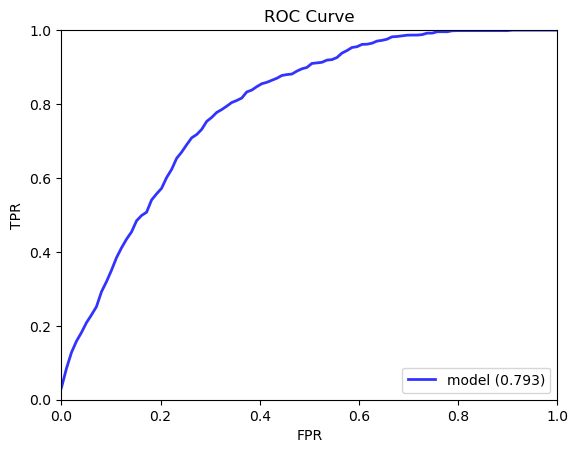

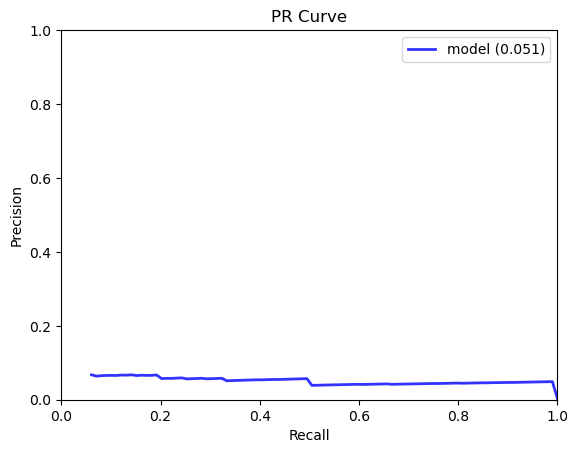

In [2]:
mean_fprs, mean_tprs, mean_recalls, mean_precs= [], [], [], []
_, c_d, cf, train_data, test_data = torch.load('circ_CNN.pth') 
# test_data = torch.load(R'E:\CompeletedMethodsCodeAndPaper\data_circ\dataset\test_data.pth') #5个2*113516
# c_d = np.load(R'E:\CompeletedMethodsCodeAndPaper\data_circ\dataset\circRNA_disease.npy') #834*138
# 以疾病为主体
for i in range(5):
    y = torch.load(rf'MPCLCDAlabel{i}')
    pred = torch.load(rf'MPCLCDAoutput{i}')
    pred = nn.functional.softmax(pred,dim=1)[:,1]
    test_idx= test_data[i].T
    test_idx= torch.stack([test_idx[:, 1], test_idx[:, 0]], dim= 1)
    mean_fpr, mean_tpr, mean_recall, mean_prec= roc_pr4_folder(test_idx, y, pred, (138, 834))
    mean_fprs.append(torch.tensor(mean_fpr)); mean_tprs.append(torch.tensor(mean_tpr)); mean_recalls.append(torch.tensor(mean_recall)); mean_precs.append(torch.tensor(mean_prec))
mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts= torch.stack(mean_fprs), torch.stack(mean_tprs), torch.stack(mean_recalls, dim= 0), torch.stack(mean_precs, dim= 0)

roc_pr4cross_val(mean_fpr_ts, mean_tpr_ts, mean_recall_ts, mean_prec_ts, 5)